In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import trim, rtrim, broadcast
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, StringType
import codecs, sys

In [2]:
spark = SparkSession.builder.getOrCreate()

### Most Popular Movie

In [15]:
schema = StructType([
    StructField("user_id", IntegerType()),
    StructField("movie_id", IntegerType()),
    StructField("rating_id", IntegerType()),
    StructField("timestamp", LongType()),
])
movieDf = spark.read.option("sep", "\t").schema(schema).csv("u.data")
movieDf.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)



In [16]:
movieDf.show(3)

+-------+--------+---------+---------+
|user_id|movie_id|rating_id|timestamp|
+-------+--------+---------+---------+
|    196|     242|        3|881250949|
|    186|     302|        3|891717742|
|     22|     377|        1|878887116|
+-------+--------+---------+---------+
only showing top 3 rows



In [ ]:
movieCount = movieDf.groupBy("movie_id").count().orderBy("count", ascending=False)
movieCount.show(10)

#### A Better Solution

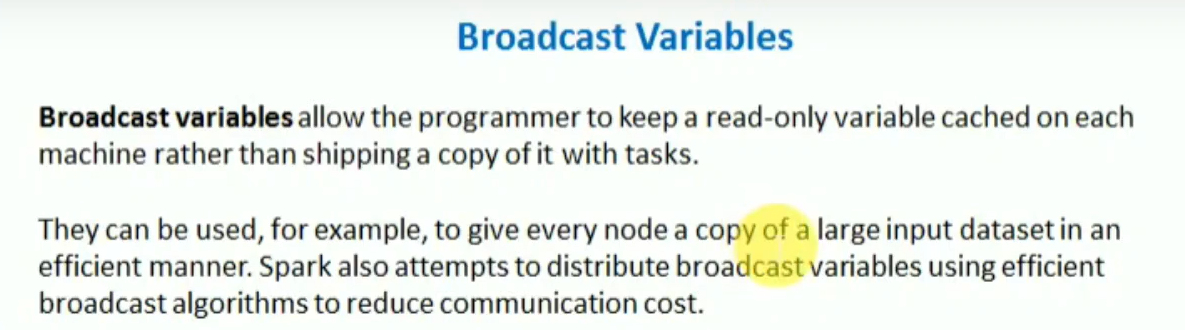

In [ ]:
def loadMovieNames():
    movieNames = {}    
    with codecs.open("u.item", "r", encoding="ISO-8859-1") as file :
        for line in file :
            fields = line.split("|")
            movieNames[int(fields[0])] = fields[1]
            
    return movieNames

nameDict = spark.sparkContext.broadcast(loadMovieNames())

In [ ]:
def movieLookup(movieId):
    return nameDict.value[movieId]

movieLookupUDF = functions.udf(movieLookup)
'''
Convert a Python function to PySpark UDF (User Defined Function)
'''
movieNameDf = movieCount.withColumn("movie_title", movieLookupUDF(movieCount.movie_id))
movieNameDf.show(10, False)

### Superhero Dataset

#### Most Popular Superhero

In [3]:
schema = StructType([
    StructField("id", IntegerType()),
    StructField("name", StringType())
])
namesDf = spark.read.schema(schema).option("sep", " ").csv("Marvel-Names")
namesDf.printSchema()
namesDf.show(3)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)

+---+--------------------+
| id|                name|
+---+--------------------+
|  1|24-HOUR MAN/EMMANUEL|
|  2|3-D MAN/CHARLES CHAN|
|  3|    4-D MAN/MERCURIO|
+---+--------------------+
only showing top 3 rows



In [4]:
movieGraph = spark.read.text("Marvel-Graph")
movieGraph.printSchema()
movieGraph.show(3)

root
 |-- value: string (nullable = true)

+--------------------+
|               value|
+--------------------+
|5988 748 1722 375...|
|5989 4080 4264 44...|
|5982 217 595 1194...|
+--------------------+
only showing top 3 rows



In [5]:
connectionsDf = movieGraph.withColumn("id", functions.split(movieGraph.value, " ")[0])\
    .withColumn("connections", functions.size(functions.split(rtrim(movieGraph.value), " "))-1)\
    .groupBy("id").agg(functions.sum("connections").alias("connections"))

connectionsDf.show(3)

+----+-----------+
|  id|connections|
+----+-----------+
| 691|          6|
|1159|         11|
|3959|        142|
+----+-----------+
only showing top 3 rows



In [6]:
mostPopular = connectionsDf.sort("connections", ascending=False).first()
superheroName = namesDf.filter(namesDf.id == mostPopular.id).select("name").first().name
superheroConnect = mostPopular.connections
print("Superhero '"+superheroName+"' with "+str(superheroConnect)+" co-appearances")

Superhero 'CAPTAIN AMERICA' with 1933 co-appearances


#### Most Obscure Hero

In [7]:
minConnection = connectionsDf.agg(functions.min("connections")).first()[0]

In [8]:
minConnectsDf = connectionsDf.filter(connectionsDf.connections == minConnection)
minConnectsDf.show(5)

+----+-----------+
|  id|connections|
+----+-----------+
| 467|          0|
| 577|          0|
|3490|          0|
|3489|          0|
|2139|          0|
+----+-----------+
only showing top 5 rows



<b>[!! Info about Broadcast Join](https://sparkbyexamples.com/pyspark/pyspark-broadcast-join-with-example/)

In [9]:
obscureDf = namesDf.join(functions.broadcast(minConnectsDf),\
                         namesDf.id == minConnectsDf.id, "inner")\
                        .drop(connectionsDf.id)

obscureDf.select("id", "name").show()

+----+--------------------+
|  id|                name|
+----+--------------------+
| 467|        BERSERKER II|
| 577|              BLARE/|
| 835|     CALLAHAN, DANNY|
|1089|       CLUMSY FOULUP|
|1408|         DEATHCHARGE|
|1841|              FENRIS|
|2117|GERVASE, LADY ALYSSA|
|2139|      GIURESCU, RADU|
|2911|                KULL|
|3014|JOHNSON, LYNDON BAIN|
|3298|          LUNATIK II|
|3489|MARVEL BOY/MARTIN BU|
|3490|MARVEL BOY II/MARTIN|
|4517|              RANDAK|
|4602|         RED WOLF II|
|4784|                RUNE|
|4945|         SEA LEOPARD|
|5028|           SHARKSKIN|
|6411|              ZANTOR|
+----+--------------------+



#### Superhero Degrees of Separation

[**!!! Info about Accumulator**](https://sparkbyexamples.com/pyspark/pyspark-accumulator-with-example/)

In [8]:
startCharcId = 5306
targetCharcId = 14
'''
If target is found increase counter
'''
counter = spark.sparkContext.accumulator(0)

In [9]:
def convertToBFS(line):
    fields = line.split() 
    heroId = int(fields[0])
    connections = []
    for connection in fields[1:] :
        connections.append(int(connection))
    
    color = "WHITE"
    distance = 9999
    if(heroId == startCharcId):
        color = "GRAY"
        distance = 0
        
    return (heroId, (connections, distance, color))

In [10]:
def bfsMap(node):
    heroId = node[0]
    connections = node[1][0]
    distance = node[1][1]
    color = node[1][2]
    results = []
    if (color == "GRAY"):
        for connection in connections :
            if(connection == targetCharcId): counter.add(1)
            newDistance = distance+1
            results.append((connection, ([], int(newDistance), "GRAY")))            
            
    color = "BLACK"
    results.append((heroId, (connections, distance, color)))   
    return results     

In [11]:
def bfsReduce(data1, data2):
    connections1 = data1[0]
    connections2 = data2[0]
    distance1 = data1[1]
    distance2 = data2[1]
    color1 = data1[2]
    color2 = data2[2]
    color = color1
    connections = []

    if(len(connections1)>0): 
        connections.extend(connections1)
        
    if(len(connections2)>0): 
        connections.extend(connections2)
    
    distance = 0
    if(int(distance1)<9999): 
        distance = distance1

    if(distance2<9999): 
        distance = distance2    
        
    return (connections, distance, color)

In [13]:
iterRdd = spark.sparkContext.textFile("Marvel-Graph").map(convertToBFS)
for iteration in range(10):
    print("Running BFS iteration# " + str(iteration+1))
    mapBfsRdd = iterRdd.flatMap(bfsMap)    
    print("Processing " + str(mapBfsRdd.count()) + " values.")
    if (counter.value > 0):
        print("Hit the target character! From " + str(counter.value) \
            + " different direction(s).")
        break    
        
    iterRdd = mapBfsRdd.reduceByKey(bfsReduce)

Running BFS iteration# 1
Processing 8330 values.
Running BFS iteration# 2
Processing 18360 values.
Running BFS iteration# 3
Processing 129503 values.
Hit the target character! From 1 different direction(s).


### Item Based Collaborative Filtering

In [3]:
movieSchema = StructType([
    StructField("user_id", IntegerType()),
    StructField("movie_id", IntegerType()),
    StructField("rating", IntegerType()),
    StructField("timestamp", LongType()),
])
movieDf = spark.read.option("sep", "\t").schema(movieSchema).csv("u.data")
movieDf.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: long (nullable = true)



In [4]:
movieDf.show(3)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
+-------+--------+------+---------+
only showing top 3 rows



In [5]:
movieNameSchema = StructType([
    StructField("movie_id", IntegerType()),
    StructField("movie_title", StringType()),
])
movieNameDf = spark.read.option("sep", "|").option("charset", "ISO-8859-1")\
        .schema(movieNameSchema).csv("u.item")
movieNameDf.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- movie_title: string (nullable = true)



In [6]:
movieNameDf.show(3)

+--------+-----------------+
|movie_id|      movie_title|
+--------+-----------------+
|       1| Toy Story (1995)|
|       2| GoldenEye (1995)|
|       3|Four Rooms (1995)|
+--------+-----------------+
only showing top 3 rows



In [7]:
ratings = movieDf.select("user_id", "movie_id", "rating")
'''
Find Every movie rated by the same user
'''
moviePair = ratings.alias("ratings1").join(
    broadcast(ratings.alias("ratings2")),
    (functions.col("ratings1.user_id") == functions.col("ratings2.user_id"))\
    & (functions.col("ratings1.movie_id") < functions.col("ratings2.movie_id")))\
    .select(functions.col("ratings1.movie_id").alias("movie1"), \
            functions.col("ratings2.movie_id").alias("movie2"), \
            functions.col("ratings1.rating").alias("rating1"), \
            functions.col("ratings2.rating").alias("rating2"))

moviePair.printSchema()

root
 |-- movie1: integer (nullable = true)
 |-- movie2: integer (nullable = true)
 |-- rating1: integer (nullable = true)
 |-- rating2: integer (nullable = true)



In [8]:
moviePair.show(3)

+------+------+-------+-------+
|movie1|movie2|rating1|rating2|
+------+------+-------+-------+
|   242|   269|      3|      3|
|   242|   845|      3|      4|
|   242|  1022|      3|      4|
+------+------+-------+-------+
only showing top 3 rows



In [70]:
def cosineSimilarity(spark, data):
    # compute xx yy xy
    pairScores = data \
        .withColumn("xy", functions.col("rating1")*functions.col("rating2"))\
        .withColumn("xx", functions.col("rating1")*functions.col("rating1"))\
        .withColumn("yy", functions.col("rating2")*functions.col("rating2"))
    
    similarity = pairScores \
        .groupBy("movie1", "movie2")\
        .agg(
            functions.sum(functions.col("xy")).alias("num"), \
            functions.sqrt(functions.sum(functions.col("xx"))*functions.sum(functions.col("yy"))).alias("denom"),
            functions.count(functions.col("xy")).alias("num_pairs"))
    
    result = similarity \
        .withColumn("score", \
            functions.when(functions.col("denom")!=0, functions.col("num")/functions.col("denom"))\
                    .otherwise(0) \
        ).select("movie1", "movie2", "score", "num_pairs")
    
    return result
    
moviePairSimiliratity = cosineSimilarity(spark, moviePair).cache()

In [71]:
def getMovieName(data, movieId):
    return data.filter(data.movie_id == movieId).select("movie_title").collect()[0][0]

In [77]:
scoreThreshold = 0.97
coOccurenceThreshold = 50
movieId = 100
results = moviePairSimiliratity.filter(
    (functions.col("movie1") == movieId)|(functions.col("movie2") == movieId))   
results = results.filter(
    (functions.col("score") > scoreThreshold)&(functions.col("num_pairs")>coOccurenceThreshold)) 
results = results.sort(functions.col("score").desc()).take(10)
print("Top 10 similar movies to "+getMovieName(movieNameDf, movieId))
for result in results :
    similarMovie = result.movie2 if result.movie1 == movieId else result.movie1
    print(getMovieName(movieNameDf, similarMovie)+" Score: "+f"{result.score:.2f}" \
         +" Strength: "+str(result.num_pairs))

Top 10 similar movies to Fargo (1996)
Manchurian Candidate, The (1962) Score: 0.98 Strength: 98
Eat Drink Man Woman (1994) Score: 0.98 Strength: 66
Rear Window (1954) Score: 0.98 Strength: 148
Sling Blade (1996) Score: 0.97 Strength: 123
Smoke (1995) Score: 0.97 Strength: 67
Secrets & Lies (1996) Score: 0.97 Strength: 140
Lone Star (1996) Score: 0.97 Strength: 171
Third Man, The (1949) Score: 0.97 Strength: 55
L.A. Confidential (1997) Score: 0.97 Strength: 159
Bullets Over Broadway (1994) Score: 0.97 Strength: 72
